<a href="https://colab.research.google.com/github/SebastianJia/Recommender_system/blob/master/tmdb_movie_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install surprise

     |████████████████████████████████| 3.3MB 4.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.0.6-cp36-cp36m-linux_x86_64.whl size=1683488 sha256=9d3dd64fa840bfbdb49b09d389ae2e94c4aba9ba97c49da323081af636bb7513
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate
import warnings; warnings.simplefilter('ignore')

In [0]:
from tqdm import tqdm_notebook as tqdm

# Download Datasets

In [3]:
!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/
!kaggle datasets download -d tmdb/tmdb-movie-metadata

 54% 5.00M/9.30M [00:00<00:00, 32.1MB/s]
100% 9.30M/9.30M [00:00<00:00, 45.6MB/s]


In [4]:
!kaggle datasets download -d rounakbanik/the-movies-dataset
!unzip tmdb-movie-metadata.zip
!unzip the-movies-dataset.zip

 99% 225M/228M [00:02<00:00, 99.9MB/s]
100% 228M/228M [00:02<00:00, 80.8MB/s]
Archive:  tmdb-movie-metadata.zip
  inflating: tmdb_5000_credits.csv   
  inflating: tmdb_5000_movies.csv    
Archive:  the-movies-dataset.zip
  inflating: ratings.csv             
  inflating: ratings_small.csv       
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: keywords.csv            
  inflating: movies_metadata.csv     
  inflating: credits.csv             


# Data Pre-processing

In [5]:
md = pd.read_csv('movies_metadata.csv')
md.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [6]:
len(md)

45466

In [0]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [8]:
md['genres'][0:5]

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genres, dtype: object

In [0]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [10]:
md['year'][0:5]

0    1995
1    1995
2    1995
3    1995
4    1995
Name: year, dtype: object

In [0]:
links_small = pd.read_csv('links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [0]:
md = md.drop([19730, 29503, 35587])
md['id'] = md['id'].astype('int')


In [0]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')


In [0]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [0]:
smd = md[md['id'].isin(links_small)]

In [0]:
smd.head(5)

In [0]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [0]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [0]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan


In [0]:
smd['director'] = smd['crew'].apply(get_director)

In [0]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [0]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

# Baseline

I use the TMDB Ratings to come up with our **Top Movies Chart.** I will use IMDB's *weighted rating* formula to construct my chart. Mathematically, it is represented as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,
* *v* is the number of votes for the movie
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the movie
* *C* is the mean vote across the whole report

In [24]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.238696808510638

In [25]:
m = vote_counts.quantile(0.5)
m

10.0

In [0]:
def weighted_score(x):
  v = x['vote_count']
  R = x['vote_average']
  return v/(v+m)*R + m/(v+m)*C

In [0]:
def build_chart(genre, percentile=0.85):
    qualified = md.copy()
    indices = [i for i in range(len(qualified)) if genre in qualified.iloc[i]['genres']]
    df = qualified.iloc[indices]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['weighted_rating'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)
    
    return qualified

In [28]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,weighted_rating
10397,Dilwale Dulhania Le Jayenge,1995,661,9,34.457,8.572162
351,Forrest Gump,1994,8147,8,48.3072,7.971846
890,Vertigo,1958,1162,8,18.2082,7.814646
41418,Your Name.,2016,1030,8,34.461252,7.792781
897,Some Like It Hot,1959,835,8,11.8451,7.749050
1153,Cinema Paradiso,1988,834,8,14.177,7.748778
20097,Paperman,2012,734,8,7.19863,7.718252
39032,Sing Street,2016,669,8,10.672862,7.694092
896,The Apartment,1960,498,8,11.9943,7.604977
39887,The Handmaiden,2016,453,8,16.727405,7.572180


In [29]:
build_chart('Adventure').head(15)

,title,year,vote_count,vote_average,popularity,weighted_rating
15651,Inception,2010,14075,8,29.1081,7.910362
23076,Interstellar,2014,11187,8,32.2135,7.888166
4904,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,7.860769
7069,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,7.850113
5876,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,7.839311
256,Star Wars,1977,6778,8,42.1497,7.820194
1246,Back to the Future,1985,6239,8,25.7785,7.805762
1175,The Empire Strikes Back,1980,5998,8,19.471,7.798531
5529,Spirited Away,2001,3968,8,41.0489,7.706503
9786,Howl's Moving Castle,2004,2049,8,16.136,7.483454


# Content Based Filtering

In [0]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [31]:
tfidf_matrix.shape

(9219, 268124)

In [0]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [0]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [0]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [35]:
get_recommendations('The Dark Knight').head(10)

8031                      The Dark Knight Rises
132                              Batman Forever
1134                             Batman Returns
8334    Batman: The Dark Knight Returns, Part 2
7659                 Batman: Under the Red Hood
524                                      Batman
8001                           Batman: Year One
2599               Batman: Mask of the Phantasm
2716                                        JFK
8265    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

# Metadata based

In [0]:
#keywords
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [38]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [0]:
s = s[s > 1]
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])


In [0]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [0]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [0]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [43]:
get_recommendations('The Dark Knight').head(10)

8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

# popularity and ranking

In [0]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_score, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [45]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.998040
8613,Interstellar,11187,8,2014,7.997534
6623,The Prestige,4510,8,2006,7.993891
3381,Memento,4168,8,2000,7.993391
8031,The Dark Knight Rises,9263,7,2012,6.998101
6218,Batman Begins,7511,7,2005,6.997658
1134,Batman Returns,1706,6,1992,5.995564
132,Batman Forever,1529,5,1995,5.001551
9024,Batman v Superman: Dawn of Justice,7189,5,2016,5.000332
1260,Batman & Robin,1447,4,1997,4.008502


# Collaborative filtering

In [46]:
reader = Reader()
ratings = pd.read_csv('ratings_small.csv')
ratings.head()


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [0]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)

In [48]:
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8992
MAE:  0.6929
------------
Fold 2
RMSE: 0.8870
MAE:  0.6860
------------
Fold 3
RMSE: 0.9017
MAE:  0.6921
------------
Fold 4
RMSE: 0.8986
MAE:  0.6925
------------
Fold 5
RMSE: 0.8958
MAE:  0.6878
------------
------------
Mean RMSE: 0.8965
Mean MAE : 0.6903
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.6929276277878237,
                             0.6860252283414467,
                             0.692086401402997,
                             0.6925427752475593,
                             0.6878066981482034],
                            'rmse': [0.8992112551789657,
                             0.8869998822735229,
                             0.9017174651809952,
                             0.898569487269415,
                             0.8957814409893712]})

In [49]:
trainset = data.build_full_trainset()
svd.train(trainset)

In [0]:
users = ratings['userId'].unique()

In [51]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [52]:
max(ratings['movieId'])

163949

In [53]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.8296254919856962, details={'was_impossible': False})

# Hybrid

In [0]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [0]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

In [0]:
indices_map = id_map.set_index('id')

In [57]:
id_map

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0
Heat,6,949.0
Sabrina,7,11860.0
Tom and Huck,8,45325.0
Sudden Death,9,9091.0


In [0]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [59]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,3.118462
1011,The Terminator,4208.0,7.4,1984,218,3.049829
2014,Fantastic Planet,140.0,7.6,1973,16306,2.957475
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,2.877246
974,Aliens,3282.0,7.7,1986,679,2.875747
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,2.871731
1621,Darby O'Gill and the Little People,35.0,6.7,1959,18887,2.799790
344,True Lies,1138.0,6.8,1994,36955,2.784013
4347,Piranha Part Two: The Spawning,41.0,3.9,1981,31646,2.743995
1668,Return from Witch Mountain,38.0,5.6,1978,14822,2.714989


#Autoencoder 

In [0]:
indices_map = id_map.copy()

In [0]:
indices_map = indices_map.reset_index()

In [62]:
indices_map


,title,movieId,id
0,Toy Story,1,862.0
1,Jumanji,2,8844.0
2,Grumpier Old Men,3,15602.0
3,Waiting to Exhale,4,31357.0
4,Father of the Bride Part II,5,11862.0
5,Heat,6,949.0
6,Sabrina,7,11860.0
7,Tom and Huck,8,45325.0
8,Sudden Death,9,9091.0
9,GoldenEye,10,710.0


In [0]:
movieid2idx = dict(zip(indices_map.movieId, list(range(len(indices_map)))))

In [80]:
movieid2idx

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 34: 32,
 35: 33,
 36: 34,
 37: 35,
 38: 36,
 39: 37,
 40: 38,
 41: 39,
 42: 40,
 43: 41,
 44: 42,
 45: 43,
 46: 44,
 47: 45,
 48: 46,
 49: 47,
 50: 48,
 52: 49,
 53: 50,
 54: 51,
 55: 52,
 57: 53,
 58: 54,
 59: 55,
 60: 56,
 61: 57,
 62: 58,
 63: 59,
 64: 60,
 65: 61,
 66: 62,
 68: 63,
 69: 64,
 70: 65,
 71: 66,
 72: 67,
 73: 68,
 74: 69,
 76: 70,
 77: 71,
 78: 72,
 79: 73,
 80: 74,
 81: 75,
 82: 76,
 83: 77,
 84: 78,
 85: 79,
 86: 80,
 87: 81,
 88: 82,
 89: 83,
 92: 84,
 93: 85,
 94: 86,
 95: 87,
 96: 88,
 97: 89,
 98: 90,
 99: 91,
 100: 92,
 101: 93,
 102: 94,
 103: 95,
 104: 96,
 105: 97,
 107: 98,
 108: 99,
 110: 100,
 111: 101,
 112: 102,
 113: 103,
 114: 104,
 116: 105,
 117: 106,
 118: 107,
 119: 108,
 121: 109,
 

In [0]:
idx2movieid = dict(zip(list(range(len(indices_map))),indices_map.movieId))

In [0]:
users = ratings['userId'].unique()

In [0]:
ratings_train = ratings[ratings['userId'] < 500]
ratings_test =ratings[ratings['userId'] >= 500]

In [86]:
dense_matrix = np.zeros((len(users), len(indices_map)))
for i in tqdm(range(len(ratings))):
#   print(ratings.loc[i]['userId'], movieid2idx[int(ratings.loc[i]['movieId'])])
  if int(ratings.loc[i]['movieId']) in movieid2idx:
#     print(ratings.loc[i]['userId'], movieid2idx[int(ratings.loc[i]['movieId'])])
    dense_matrix[int(ratings.loc[i]['userId'])-1, movieid2idx[ratings.loc[i]['movieId']]] = ratings.loc[i]['rating']

In [87]:
dense_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

W0807 20:32:35.128355 139916988725120 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


N: 671 M: 9219
N // batch_size: 5
mu: 3.5429716461276426
Epoch 1/20
6/6 [==============================] - 4s 653ms/step - loss: 1.3898 - custom_loss: 1.1296
Epoch 2/20
6/6 [==============================] - 2s 331ms/step - loss: 1.3648 - custom_loss: 1.1048
Epoch 3/20
6/6 [==============================] - 2s 327ms/step - loss: 1.3585 - custom_loss: 1.0989
Epoch 4/20
6/6 [==============================] - 2s 329ms/step - loss: 1.3319 - custom_loss: 1.0727
Epoch 5/20
6/6 [==============================] - 2s 335ms/step - loss: 1.3226 - custom_loss: 1.0638
Epoch 6/20
6/6 [==============================] - 2s 337ms/step - loss: 1.3071 - custom_loss: 1.0487
Epoch 7/20
6/6 [==============================] - 2s 330ms/step - loss: 1.2278 - custom_loss: 0.9697
Epoch 8/20
6/6 [==============================] - 2s 331ms/step - loss: 1.1672 - custom_loss: 0.9094
Epoch 9/20
6/6 [==============================] - 2s 334ms/step - loss: 1.1221 - custom_loss: 0.8646
Epoch 10/20
6/6 [=================

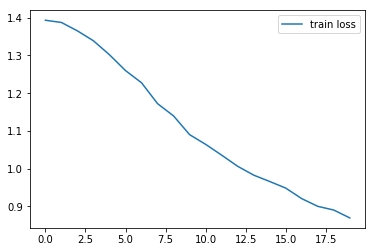

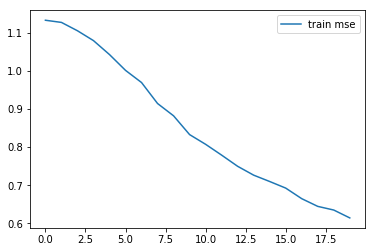

In [89]:
# https://udemy.com/recommender-systems
# https://deeplearningcourses.com/recommender-systems
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import save_npz, load_npz

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2
from keras.optimizers import SGD

A = dense_matrix.copy()
# config
batch_size = 128
epochs = 20
reg = 0.0001
# reg = 0

# A = load_npz("Atrain.npz")
# A_test = load_npz("Atest.npz")
mask = (A > 0) * 1.0
# mask_test = (A_test > 0) * 1.0

# make copies since we will shuffle
A_copy = A.copy()
mask_copy = mask.copy()
# A_test_copy = A_test.copy()
# mask_test_copy = mask_test.copy()

N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

# center the data
mu = A.sum() / mask.sum()
print("mu:", mu)



# build the model - just a 1 hidden layer autoencoder
i = Input(shape=(M,))
# bigger hidden layer size seems to help!
x = Dropout(0.7)(i)
x = Dense(700, activation='tanh', kernel_regularizer=l2(reg))(x)
# x = Dropout(0.5)(x)
x = Dense(M, kernel_regularizer=l2(reg))(x)



def custom_loss(y_true, y_pred):
  mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
  diff = y_pred - y_true
  sqdiff = diff * diff * mask
  sse = K.sum(K.sum(sqdiff))
  n = K.sum(K.sum(mask))
  return sse / n


def generator(A, M):
  while True:
    A, M = shuffle(A, M)
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper]
      m = M[i*batch_size:upper]
      a = a - mu * m # must keep zeros at zero!
      # m2 = (np.random.random(a.shape) > 0.5)
      # noisy = a * m2
      noisy = a # no noise
      yield noisy, a


def test_generator(A, M, A_test, M_test):
  # assumes A and A_test are in corresponding order
  # both of size N x M
  while True:
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      at = A_test[i*batch_size:upper].toarray()
      mt = M_test[i*batch_size:upper].toarray()
      a = a - mu * m
      at = at - mu * mt
      yield a, at



model = Model(i, x)
model.compile(
  loss=custom_loss,
  optimizer=SGD(lr=0.08, momentum=0.9),
  # optimizer='adam',
  metrics=[custom_loss],
)


r = model.fit_generator(
  generator(A, mask),
#   validation_data=test_generator(A_copy, mask_copy, A_test_copy, mask_test_copy),
  epochs=epochs,
  steps_per_epoch=A.shape[0] // batch_size + 1
#   validation_steps=A_test.shape[0] // batch_size + 1,
)
print(r.history.keys())



# plot losses
plt.plot(r.history['loss'], label="train loss")
# plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['custom_loss'], label="train mse")
# plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()

In [92]:
model.predict(A)

array([[ 0.2929428 ,  0.0467914 , -0.00843934, ...,  0.0136389 ,
        -0.09721554,  0.04790801],
       [ 1.2653358 ,  0.8819307 ,  0.41880143, ..., -0.16561845,
        -0.30760872, -0.15943165],
       [ 1.4325048 ,  0.20616484, -0.24474886, ...,  0.11036415,
        -0.22922158,  0.23753533],
       ...,
       [ 0.890961  ,  0.46817827,  0.0758094 , ...,  0.10133581,
        -0.13296357,  0.11947358],
       [ 1.2493023 ,  0.2596806 , -0.43567276, ...,  0.09462436,
        -0.19129738,  0.22551621],
       [ 1.9306686 ,  0.55533296, -0.7010504 , ...,  0.02818049,
        -0.45160985,  0.2086064 ]], dtype=float32)